In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import math

In [2]:
def calculate_altitude_hpa(pressure_hpa, base_pressure_pa=1013.25, temperature_k=288.15):
    """
    Calculates the altitude in meters from the atmospheric pressure in hPa using the barometric formula.
    
    :param pressure_hpa: Atmospheric pressure in hPa at the desired altitude.
    :param base_pressure_hpa: Atmospheric pressure in hPa at sea level (default 1013.25 hPa).
    :param temperature_k: Average temperature in Kelvin in the atmospheric layer (default 288.15 K).
    :return: Altitude in meters.
    """
    R = 287.05  # Ideal gas constant for dry air, in J/(kg·K)
    g = 9.80665  # Acceleration due to gravity, in m/s^2

    # Convert pressure from hPa to Pascal for calculation
    pressure_pa = pressure_hpa * 100

    # Barometric formula for an isothermal atmosphere
    altitude = (math.log(base_pressure_pa / pressure_pa) * (R * temperature_k)) / g
    return altitude

In [3]:
!ls C:\\Users\\LPS04\\Desktop\\Edith\\Weather_Data\\Reanalysis_ERA5\\Vertical_Profile\\

geopotential1000hPa1999 2003geopotential1000hPa1999 2003geopotential1000hPa1999 2003geopotential1000hPa1999 2003.nc
geopotential1000hPa2004 2008geopotential1000hPa2004 2008geopotential1000hPa2004 2008geopotential1000hPa2004 2008.nc
geopotential1000hPa2009 2013geopotential1000hPa2009 2013geopotential1000hPa2009 2013geopotential1000hPa2009 2013.nc
geopotential1000hPa2014 2018geopotential1000hPa2014 2018geopotential1000hPa2014 2018geopotential1000hPa2014 2018.nc
geopotential1000hPa2019 2023geopotential1000hPa2019 2023geopotential1000hPa2019 2023geopotential1000hPa2019 2023.nc
geopotential100hPa1999 2003geopotential100hPa1999 2003geopotential100hPa1999 2003geopotential100hPa1999 2003.nc
geopotential100hPa2004 2008geopotential100hPa2004 2008geopotential100hPa2004 2008geopotential100hPa2004 2008.nc
geopotential100hPa2009 2013geopotential100hPa2009 2013geopotential100hPa2009 2013geopotential100hPa2009 2013.nc
geopotential100hPa2014 2018geopotential100hPa2014 2018geopotential100hPa2014 2018geo

In [4]:
def create_variable_dataset(variable, pressure_levels, year_interval):
    datasets = []  # Lista para armazenar os datasets temporários

    for pressure_level in pressure_levels:
        # load dataset
        pl_variable = xr.open_dataset(
           f"C:\\Users\\LPS04\\Desktop\\Edith\\Weather_Data\\Reanalysis_ERA5\\Vertical_Profile\\{variable}_{pressure_level}hPa_{year_interval}.nc"
        )
        # get mean from lat and lon
        pl_variable = pl_variable.mean(dim=['latitude', 'longitude'])
        
        # Add the pressure level dimension with the current pressure_level value
        pl_variable_expanded = pl_variable.expand_dims("pressure_level")
        pl_variable_expanded['pressure_level'] = [pressure_level]
        
        # Store the expanded dataset in the list
        datasets.append(pl_variable_expanded)

    # Concatenate all datasets along the new 'pressure_level
    variable_dataset = xr.concat(datasets, dim="pressure_level")

    return variable_dataset

pressure_levels = [
    1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000
]

def create_pl_dataset_by_year_interval(year_interval):
    temperature = create_variable_dataset("temperature", pressure_levels, year_interval)
    # rename the variable
    temperature = temperature.rename_vars({"t": "temperature"})

    relative_humidity = create_variable_dataset("relative_humidity", pressure_levels, year_interval)
    relative_humidity = relative_humidity.rename_vars({"r": "relative_humidity"})

    # specific_humidity = create_variable_dataset("specific_humidity", pressure_levels, year_interval)
    # specific_humidity = specific_humidity.rename_vars({"q": "specific_humidity"})

    u_component_of_wind = create_variable_dataset("u_component_of_wind", pressure_levels, year_interval)
    v_component_of_wind = create_variable_dataset("v_component_of_wind", pressure_levels, year_interval)

    # geopotential = create_variable_dataset("geopotential", pressure_levels, year_interval)
    # geopotential = geopotential.rename_vars({"z": "geopotential"})
    # concatenate all variables
    vertical_profile_ds = xr.merge([
        temperature, 
        relative_humidity, 
        # specific_humidity, 
        u_component_of_wind, 
        v_component_of_wind, 
        # geopotential
    ])

    return vertical_profile_ds

vertical_profile_ds = xr.merge([
    create_pl_dataset_by_year_interval("1999_2003"),
    create_pl_dataset_by_year_interval("2004_2008"),
    create_pl_dataset_by_year_interval("2009_2013"),
    # create_dataset_by_year_interval("2014_2018")
])


In [5]:
columns = [
    'pressure_level', 'time', 'day', 'month', 'year', 'hour', 'temperature',
    'relative_humidity', 'u', 'v'
]

vertical_profile_df = vertical_profile_ds.to_dataframe().reset_index()
vertical_profile_df['time'] = vertical_profile_df['time'] - pd.Timedelta(hours=3)
vertical_profile_df['day'] = vertical_profile_df.time.dt.day
vertical_profile_df['month'] = vertical_profile_df.time.dt.month
vertical_profile_df['year'] = vertical_profile_df.time.dt.year
vertical_profile_df['hour'] = vertical_profile_df.time.dt.hour
vertical_profile_df = vertical_profile_df[columns]
vertical_profile_df.head()

,pressure_level,time,day,month,year,hour,temperature,relative_humidity,u,v
0,1,1998-12-31 21:00:00,31,12,1998,21,266.782809,0.000164,-53.115034,-1.046399
1,100,1998-12-31 21:00:00,31,12,1998,21,193.243026,92.641346,11.840332,-0.521101
2,200,1998-12-31 21:00:00,31,12,1998,21,220.073902,44.306563,22.873739,1.712744
3,300,1998-12-31 21:00:00,31,12,1998,21,242.922846,68.250504,15.874313,-3.880887
4,400,1998-12-31 21:00:00,31,12,1998,21,257.739062,25.067385,5.901133,-7.892295


In [6]:
# load single level variables

def create_pl_dataset_by_year_interval(year_interval):
    temperature_2m = xr.open_dataset(f"C:\\Users\\LPS04\\Desktop\\Edith\\Weather_Data\\Reanalysis_ERA5\\Single_Level\\2m_temperature_{year_interval}.nc")
    temperature_2m = temperature_2m.mean(dim=['latitude', 'longitude'])

    uwind = xr.open_dataset(f"C:\\Users\\LPS04\\Desktop\\Edith\\Weather_Data\\Reanalysis_ERA5\\Single_Level\\10m_u_component_of_wind_{year_interval}.nc")
    uwind = uwind.mean(dim=['latitude', 'longitude'])

    vwind = xr.open_dataset(f"C:\\Users\\LPS04\\Desktop\\Edith\\Weather_Data\\Reanalysis_ERA5\\Single_Level\\10m_v_component_of_wind_{year_interval}.nc")
    vwind = vwind.mean(dim=['latitude', 'longitude'])

    mean_sea_level_pressure = xr.open_dataset(f"C:\\Users\\LPS04\\Desktop\\Edith\\Weather_Data\\Reanalysis_ERA5\\Single_Level\\mean_sea_level_pressure_{year_interval}.nc")
    mean_sea_level_pressure = mean_sea_level_pressure.mean(dim=['latitude', 'longitude'])

    single_level_ds = xr.merge([
        temperature_2m,
        uwind,
        vwind,
        mean_sea_level_pressure
    ])

    return single_level_ds

single_level_ds = xr.merge([
    create_pl_dataset_by_year_interval("1999_2003"),
    create_pl_dataset_by_year_interval("2004_2008"),
    create_pl_dataset_by_year_interval("2009_2013"),
    # create_dataset_by_year_interval("2014_2018")
])

In [7]:
columns = [
    'time', 'day', 'month', 'year', 'hour', 't2m', 'u10', 'v10', 'msl'
]

single_level_df = single_level_ds.to_dataframe().reset_index()
single_level_df['day'] = single_level_df.time.dt.day
single_level_df['month'] = single_level_df.time.dt.month
single_level_df['year'] = single_level_df.time.dt.year
single_level_df['hour'] = single_level_df.time.dt.hour
single_level_df = single_level_df[columns]
single_level_df.head()

,time,day,month,year,hour,t2m,u10,v10,msl
0,1999-01-01 00:00:00,1,1,1999,0,293.092144,-1.475597,0.648034,101323.855318
1,1999-01-01 01:00:00,1,1,1999,1,293.165837,-1.384500,-0.232797,101362.271230
2,1999-01-01 02:00:00,1,1,1999,2,292.859418,-0.960242,-0.927978,101384.923973
3,1999-01-01 03:00:00,1,1,1999,3,292.015647,-0.514787,-1.210370,101371.079419
4,1999-01-01 04:00:00,1,1,1999,4,291.947554,-0.089466,-1.281291,101300.243267


In [8]:
df_full = []
for level in pressure_levels:
    # put single level for each pressure level
    temp = vertical_profile_df[vertical_profile_df['pressure_level'] == level].reset_index(drop=True)
    temp = pd.concat([temp, single_level_df.iloc[:, 5:]], axis=1)
    df_full.append(temp)

df_full = pd.concat(df_full).reset_index()
df_full.head()
    

,index,pressure_level,time,day,month,year,hour,temperature,relative_humidity,u,v,t2m,u10,v10,msl
0,0,1,1998-12-31 21:00:00,31,12,1998,21,266.782809,0.000164,-53.115034,-1.046399,293.092144,-1.475597,0.648034,101323.855318
1,1,1,1998-12-31 22:00:00,31,12,1998,22,266.133571,0.000173,-56.079982,4.207988,293.165837,-1.384500,-0.232797,101362.271230
2,2,1,1998-12-31 23:00:00,31,12,1998,23,266.425400,0.000167,-59.579416,11.225047,292.859418,-0.960242,-0.927978,101384.923973
3,3,1,1999-01-01 00:00:00,1,1,1999,0,265.834933,0.000179,-61.247199,15.127236,292.015647,-0.514787,-1.210370,101371.079419
4,4,1,1999-01-01 01:00:00,1,1,1999,1,264.006273,0.000209,-63.268755,15.352730,291.947554,-0.089466,-1.281291,101300.243267


In [9]:
# calculate altitude
df_full['altitude'] = df_full.apply(
    lambda x: calculate_altitude_hpa(x['pressure_level'], x['msl'], x['t2m']), 
    axis=1
)

df_full.head()

,index,pressure_level,time,day,month,year,hour,temperature,relative_humidity,u,v,t2m,u10,v10,msl,altitude
0,0,1,1998-12-31 21:00:00,31,12,1998,21,266.782809,0.000164,-53.115034,-1.046399,293.092144,-1.475597,0.648034,101323.855318,59375.060548
1,1,1,1998-12-31 22:00:00,31,12,1998,22,266.133571,0.000173,-56.079982,4.207988,293.165837,-1.384500,-0.232797,101362.271230,59393.242230
2,2,1,1998-12-31 23:00:00,31,12,1998,23,266.425400,0.000167,-59.579416,11.225047,292.859418,-0.960242,-0.927978,101384.923973,59333.079575
3,3,1,1999-01-01 00:00:00,1,1,1999,0,265.834933,0.000179,-61.247199,15.127236,292.015647,-0.514787,-1.210370,101371.079419,59160.964827
4,4,1,1999-01-01 01:00:00,1,1,1999,1,264.006273,0.000209,-63.268755,15.352730,291.947554,-0.089466,-1.281291,101300.243267,59141.195923


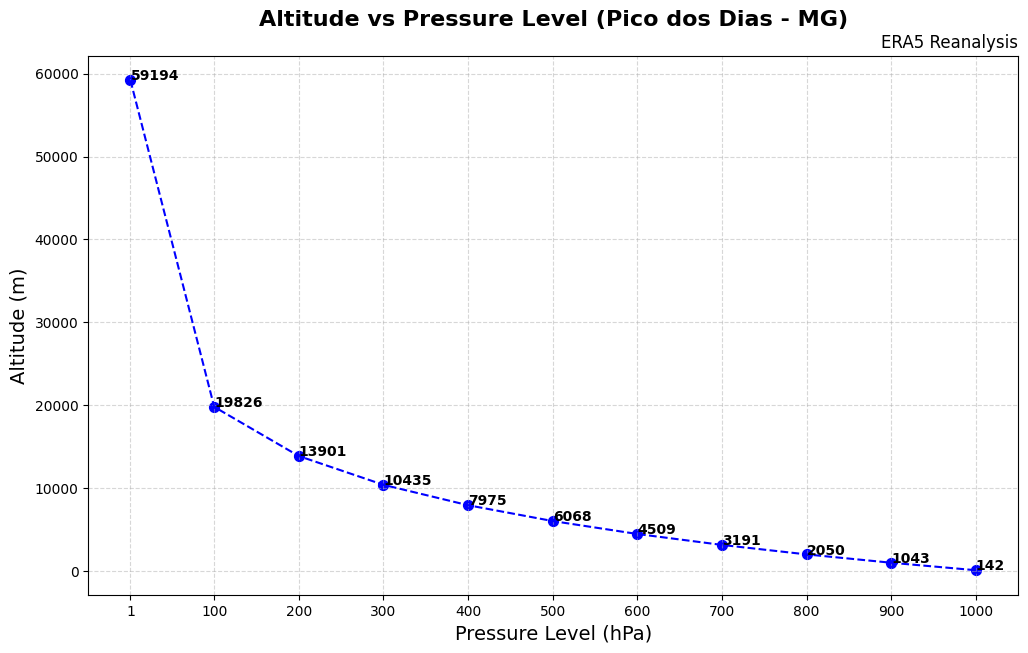

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))

pl_vs_altitude = df_full.groupby('pressure_level')['altitude'].mean().reset_index()
pl_vs_altitude.plot(x='pressure_level', y='altitude', kind='scatter', color='blue', s=50, ax=ax)
pl_vs_altitude.plot(x='pressure_level', y='altitude', kind='line', ls='--', color='blue', ax=ax)
# adding annotation
# show all x ticks
plt.xticks(pl_vs_altitude['pressure_level'])
ax.grid(ls='--', alpha=0.5)
plt.xlabel('Pressure Level (hPa)', fontsize=14)
plt.ylabel('Altitude (m)', fontsize=14)
# removing legend
ax.get_legend().remove()
ax.set_title('Altitude vs Pressure Level (Pico dos Dias - MG)', fontsize=16, fontweight='bold', y=1.04)
ax.set_title('ERA5 Reanalysis', fontsize=12, loc='right')

for i, txt in enumerate(pl_vs_altitude['altitude']):
    ax.annotate(f"{int(txt)}", (pl_vs_altitude['pressure_level'][i], pl_vs_altitude['altitude'][i]), fontweight='bold')


   # plt.savefig('../images/altitude_vs_pressure_level.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    

In [ ]:
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['path.simplify']    = True
plt.rcParams['font.family']  = 'monospace'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 3    
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.handletextpad'] = 0.3
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

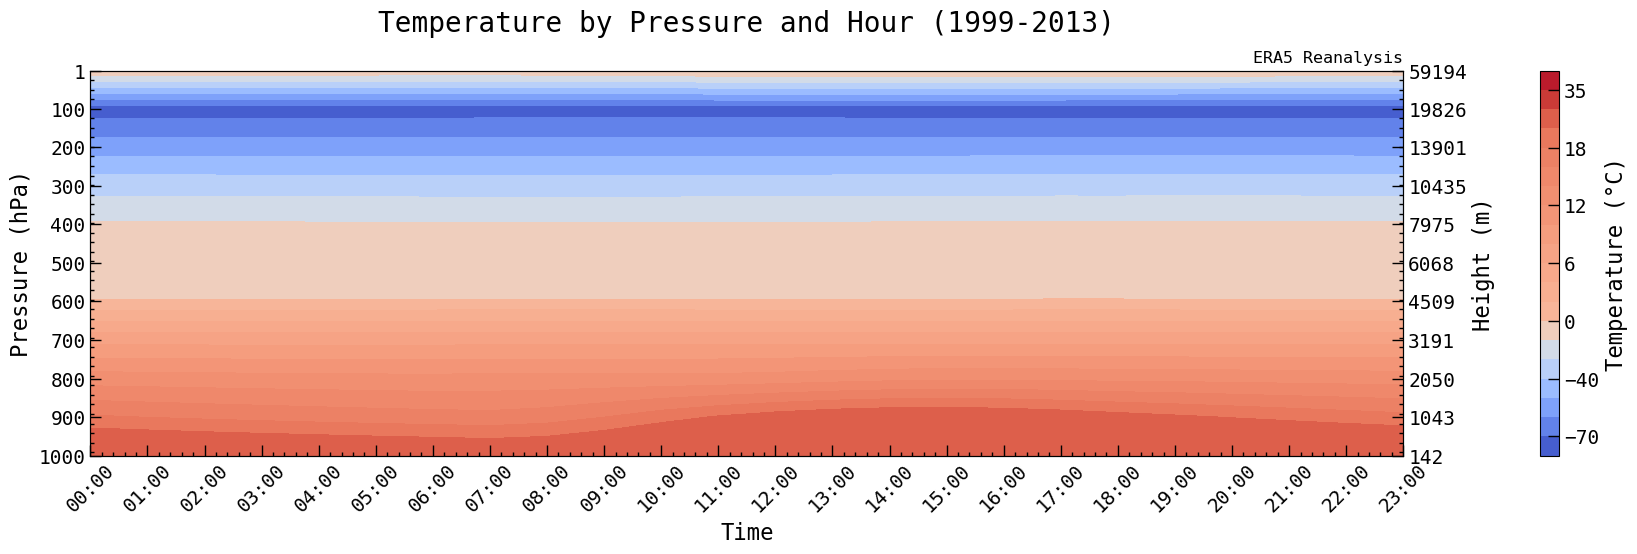

In [ ]:
vp_temperature = df_full.groupby(["hour", "pressure_level"]).agg({'temperature': 'mean'}).reset_index()
# K -> C
vp_temperature['temperature'] = vp_temperature['temperature'] - 273.15 

pivot = vp_temperature.pivot(index='pressure_level', columns='hour', values='temperature')
# pivot.index = pl_vs_altitude.sort_values('pressure_level')['altitude']
X, Y = np.meshgrid(pivot.columns, pivot.index)
Z = pivot.values

fig, ax = plt.subplots(1, 1, figsize=(22, 5))

# creating levels where 0 is in the middle
# levels = [-75, -50, -25, 0, 5, 10, 15, 20, 25, 30, 35, 40]
min_level = -75
max_level = 40
zero_level = 0
levels = [-80, -70, -60, -50, -40, -30, -20, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 35, 40,]

contour = ax.contourf(X, Y, Z, cmap='coolwarm', levels=levels)
plt.yticks(pivot.index)
xticks = [f"{str(int(x)).zfill(2)}:00" for x in pivot.columns.values]
ax.set_xticks(pivot.columns, xticks, rotation=45)
ax.set_title('Temperature by Pressure and Hour (1999-2013)', y=1.08)
ax.set_title('ERA5 Reanalysis', fontsize=12, loc='right')
ax.set_xlabel('Time')
ax.set_ylabel('Pressure (hPa)')
plt.colorbar(contour, label='Temperature (°C)', pad=0.08)

plt.gca().invert_yaxis()  # Inverter o eixo y para que a pressão decresça com a altura

ax2 = ax.twinx()
contour = ax2.contourf(X, Y, Z, cmap='coolwarm', levels=levels, alpha=0)
plt.yticks(pivot.index, [int(x) for x in pl_vs_altitude['altitude'].sort_values(ascending=False)])
xticks = [f"{str(int(x)).zfill(2)}:00" for x in pivot.columns.values]
ax2.set_ylabel("Height (m)")
plt.xticks(pivot.columns, xticks)
plt.gca().invert_yaxis()  



# Formatando o eixo x para mostrar as datas corretamente
# plt.xticks(ticks=pivot.columns, labels=pd.to_datetime(pivot.columns).strftime('%Y-%m-%d %H:%M'), rotation=45)
plt.savefig('../images/temperature_by_pressure_and_time.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

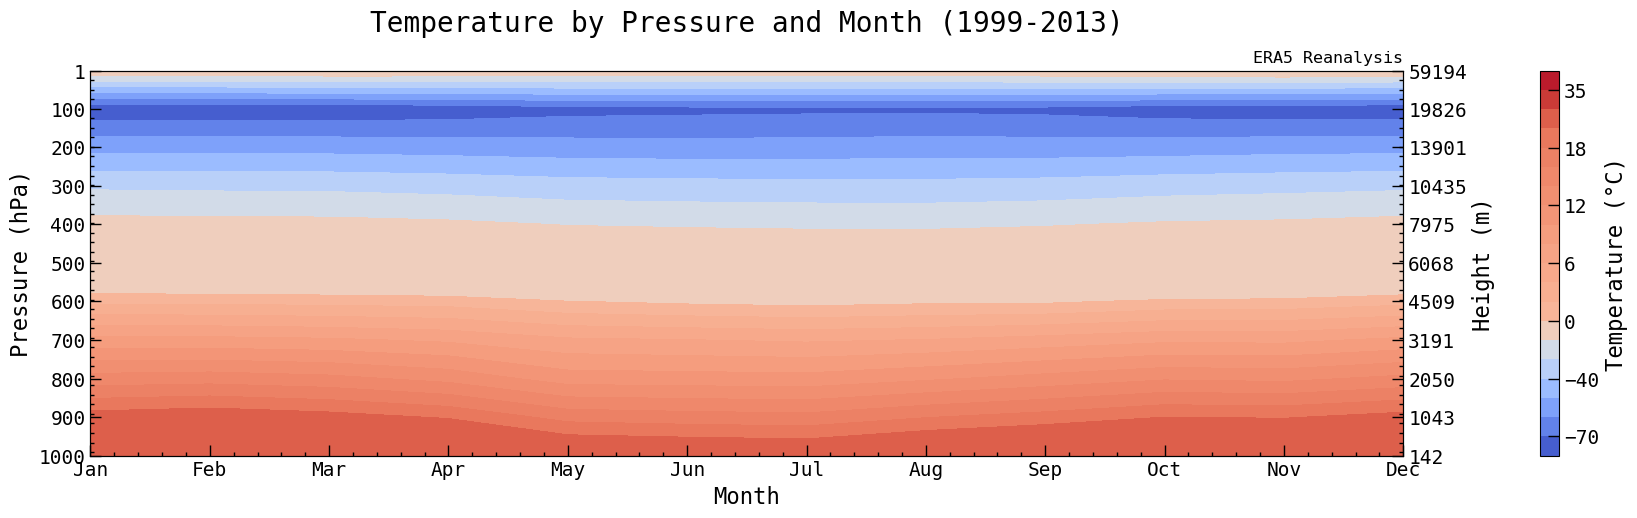

In [ ]:
vp_temperature = df_full.groupby(["month", "pressure_level"]).agg({'temperature': 'mean'}).reset_index()
# K -> C
vp_temperature['temperature'] = vp_temperature['temperature'] - 273.15 

pivot = vp_temperature.pivot(index='pressure_level', columns='month', values='temperature')
# pivot.index = pl_vs_altitude.sort_values('pressure_level')['altitude']
X, Y = np.meshgrid(pivot.columns, pivot.index)
Z = pivot.values

fig, ax = plt.subplots(1, 1, figsize=(22, 5))

# creating levels where 0 is in the middle
# levels = [-75, -50, -25, 0, 5, 10, 15, 20, 25, 30, 35, 40]
min_level = -75
max_level = 40
zero_level = 0
levels = [-80, -70, -60, -50, -40, -30, -20, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 35, 40,]

contour = ax.contourf(X, Y, Z, cmap='coolwarm', levels=levels)
plt.yticks(pivot.index)
xticks = [f"{str(int(x)).zfill(2)}:00" for x in pivot.columns.values]
months = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
]
ax.set_xticks(pivot.columns, months, rotation=0)
ax.set_title('Temperature by Pressure and Month (1999-2013)', y=1.08)
ax.set_title('ERA5 Reanalysis', fontsize=12, loc='right')
ax.set_xlabel('Month')
ax.set_ylabel('Pressure (hPa)')
plt.colorbar(contour, label='Temperature (°C)', pad=0.08)

plt.gca().invert_yaxis()  # Inverter o eixo y para que a pressão decresça com a altura

ax2 = ax.twinx()
contour = ax2.contourf(X, Y, Z, cmap='coolwarm', levels=levels, alpha=0)
plt.yticks(pivot.index, [int(x) for x in pl_vs_altitude['altitude'].sort_values(ascending=False)])
xticks = [f"{str(int(x)).zfill(2)}" for x in pivot.columns.values]
ax2.set_ylabel("Height (m)")
# plt.xticks(pivot.columns, xticks)
plt.gca().invert_yaxis()  



# Formatando o eixo x para mostrar as datas corretamente
# plt.xticks(ticks=pivot.columns, labels=pd.to_datetime(pivot.columns).strftime('%Y-%m-%d %H:%M'), rotation=45)
plt.savefig('../images/temperature_by_pressure_and_month.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
datetimes = df_full.time.unique()

datasets = []
# calculating CN2 - refractive index
for datetime in datetimes:
    temp = df_full[df_full['time'] == datetime].reset_index(drop=True)
    temp['temp_diff'] = temp['temperature'].diff() / temp['altitude'].diff()
    temp['temp_diff'] = temp['temp_diff'].fillna(0)
    
    temp['hum_diff'] = temp['specific_humidity'].diff() / temp['altitude'].diff()
    temp['hum_diff'] = temp['hum_diff'].fillna(0)

    # Constants
    C_T2 = 1e-6
    C_q2 = 1e-7
    C_Tq = 0

    temp['CN2'] = C_T2 * temp['temp_diff']**2 + C_q2 * temp['hum_diff']**2 + C_Tq * temp['temp_diff'] * temp['hum_diff']
    datasets.append(temp)

new_df_full = pd.concat(datasets).reset_index(drop=True)
new_df_full.head()
    

,index,pressure_level,time,day,month,year,hour,temperature,relative_humidity,specific_humidity,...,v,geopotential,t2m,u10,v10,msl,altitude,temp_diff,hum_diff,CN2
0,0,1,1999-01-01,1,1,1999,0,266.782809,0.000164,0.000004,...,-1.046399,471092.457968,293.092144,-1.475597,0.648034,101323.855318,59375.060548,0.000000,0.000000e+00,0.000000e+00
1,0,100,1999-01-01,1,1,1999,0,193.243026,92.641346,0.000003,...,-0.521101,162410.403584,293.092144,-1.475597,0.648034,101323.855318,19866.906504,0.001861,1.458118e-11,3.464744e-12
2,0,200,1999-01-01,1,1,1999,0,220.073902,44.306563,0.000037,...,1.712744,121840.073162,293.092144,-1.475597,0.648034,101323.855318,13920.336784,-0.004512,-5.720171e-09,2.035807e-11
3,0,300,1999-01-01,1,1,1999,0,242.922846,68.250504,0.000520,...,-3.880887,94908.690170,293.092144,-1.475597,0.648034,101323.855318,10441.816490,-0.006569,-1.387171e-07,4.314626e-11
4,0,400,1999-01-01,1,1,1999,0,257.739062,25.067385,0.000645,...,-7.892295,74232.552966,293.092144,-1.475597,0.648034,101323.855318,7973.767064,-0.006003,-5.089735e-08,3.603852e-11


In [ ]:
group[1]

,index,pressure_level,time,day,month,year,hour,temperature,relative_humidity,specific_humidity,...,v,geopotential,t2m,u10,v10,msl,altitude,temp_diff,hum_diff,CN2
4,0,400,1999-01-01 00:00:00,1,1,1999,0,257.739062,25.067385,0.000645,...,-7.892295,74232.552966,293.092144,-1.475597,0.648034,101323.855318,7973.767064,-0.006003,-5.089735e-08,3.603852e-11
15,1,400,1999-01-01 01:00:00,1,1,1999,1,257.779373,34.297966,0.000884,...,-7.967830,74264.576220,293.165837,-1.384500,-0.232797,101362.271230,7979.024801,-0.006138,-1.254533e-07,3.766912e-11
26,2,400,1999-01-01 02:00:00,1,1,1999,2,257.796281,44.145949,0.001134,...,-7.236757,74242.883048,292.859418,-0.960242,-0.927978,101384.923973,7972.600617,-0.006226,-1.999125e-07,3.876051e-11
37,3,400,1999-01-01 03:00:00,1,1,1999,3,257.628548,54.185239,0.001370,...,-6.222877,74195.845141,292.015647,-0.514787,-1.210370,101371.079419,7948.463075,-0.006237,-2.895439e-07,3.890092e-11
48,4,400,1999-01-01 04:00:00,1,1,1999,4,257.367749,64.726276,0.001588,...,-4.808840,74140.711332,291.947554,-0.089466,-1.281291,101300.243267,7940.636053,-0.006181,-3.830963e-07,3.820106e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482013,43819,400,2003-12-31 19:00:00,31,12,2003,19,257.548333,78.669106,0.001902,...,-3.764836,74330.232298,298.574533,2.565486,-0.542990,101192.408362,8111.573934,-0.005606,-4.316237e-07,3.142771e-11
482024,43820,400,2003-12-31 20:00:00,31,12,2003,20,257.508564,80.212609,0.001988,...,-4.335396,74340.538356,297.719337,1.504387,-0.016850,101219.705027,8090.690702,-0.005658,-4.738072e-07,3.201759e-11
482035,43821,400,2003-12-31 21:00:00,31,12,2003,21,257.593378,79.901299,0.001994,...,-4.767026,74320.815107,294.581904,1.256777,0.588647,101247.699369,8007.813642,-0.005706,-4.880560e-07,3.255788e-11
482046,43822,400,2003-12-31 22:00:00,31,12,2003,22,258.136888,76.834294,0.002028,...,-5.250361,74298.425255,293.461057,0.134439,0.926554,101269.480014,7979.192577,-0.005918,-5.096333e-07,3.501781e-11


{1: [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0

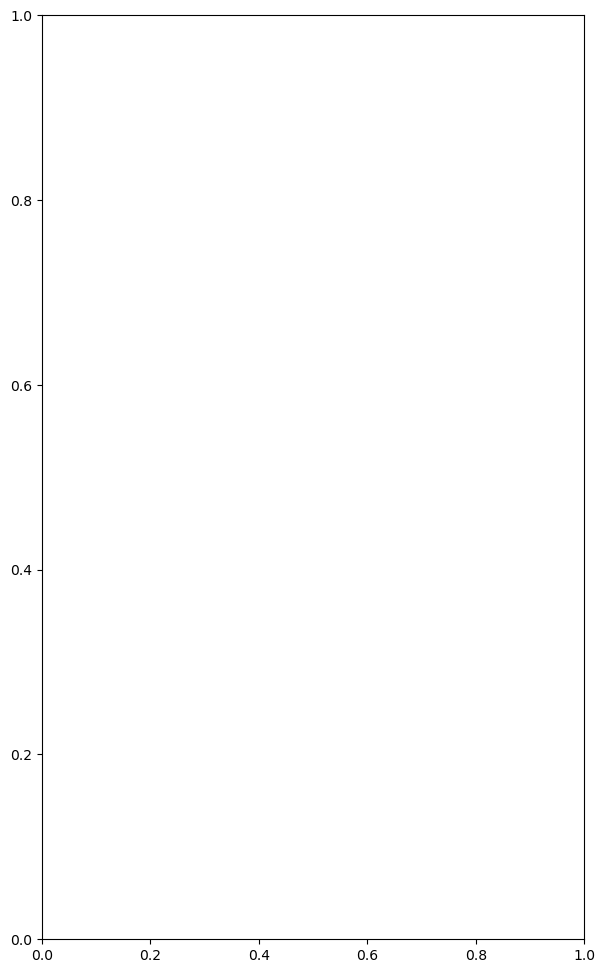

In [ ]:
fig, ax = plt.subplots(figsize=(7, 12))

cn2 = {k: [] for k in pressure_levels}

for datetime in datetimes:
    temp = new_df_full[new_df_full['time'] == datetime].reset_index(drop=True)
    for level in pressure_levels:
        cn2[level].append(temp[temp['pressure_level'] == level]['CN2'].values[0])
cn2

<Axes: xlabel='altitude', ylabel='cn2'>

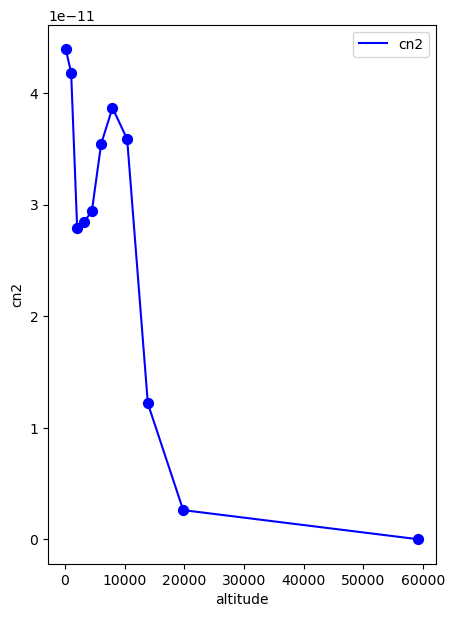

In [ ]:
group = new_df_full.groupby('pressure_level').agg({'CN2': 'mean'}).reset_index()
group.columns = ['altitude', 'cn2']
group['altitude'] = pl_vs_altitude['altitude'].values 

fig, ax = plt.subplots(figsize=(5, 7))
group.plot(y='cn2', x='altitude', kind='scatter', color='blue', s=50, ax=ax)
group.plot(y='cn2', x='altitude', kind='line', color='blue', ax=ax)

In [ ]:
def calculate_altitude(pressure, p0=101325, t0=288.15, l=0.0065, n=5.255):
    """
    Calcula a altitude baseada na pressão atmosférica.
    
    :param pressure: Pressão atmosférica em pascals.
    :param p0: Pressão ao nível do mar em pascals (padrão é 101325 Pa).
    :param t0: Temperatura ao nível do mar em kelvin (padrão é 288.15 K).
    :param l: Gradiente térmico na troposfera em K/m (padrão é 0.0065 K/m).
    :param n: Constante (padrão é 5.255).
    :return: Altitude em metros.
    """
    altitude = (p0 / pressure) ** (1 / n) - 1
    altitude *= t0 / l
    return altitude

# Exemplo de uso:
pressure_at_altitude_hPa = 250
# converting hPa to Pa
pressure_at_altitude = pressure_at_altitude_hPa * 100
altitude = calculate_altitude(pressure_at_altitude)
print(f"A altitude para a pressão de {pressure_at_altitude} Pa é de aproximadamente {altitude:.2f} metros.")


A altitude para a pressão de 25000 Pa é de aproximadamente 13527.05 metros.


In [ ]:
# calculate height of 900 hPa level
pressure_level = 900
temperature_level

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 1, latitude: 2, time: 43824)
Coordinates:
  * longitude  (longitude) float32 4B -45.7
  * latitude   (latitude) float32 8B -22.4 -22.65
  * time       (time) datetime64[ns] 351kB 1999-01-01 ... 2003-12-31T23:00:00
Data variables:
    t          (time, latitude, longitude) float64 701kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-24 02:23:27 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...